In [1]:
import sys
sys.path.append("../")

from torch import nn
from data_utils import load_mnist, load_svhn
from models import DomainAdaptationNetwork, get_simple_classifier, ProjectorNetwork

import torch
from torch.nn import functional as F
import numpy as np
from train import train_domain_adaptation
from utils import test_network, plot_tsne

In [2]:
torch.manual_seed(1)
import numpy as np
np.random.seed(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
class Decoder(nn.Module):
    def __init__(self, latent_space_dim, conv_feat_size, nb_channels=3):
        super(Decoder, self).__init__()

        self.latent_space_dim = latent_space_dim
        self.conv_feat_size = conv_feat_size

        self.deco_dense = nn.Sequential(
            nn.Linear(in_features=latent_space_dim, out_features=1024),
            nn.ReLU(True),
            nn.Linear(in_features=1024, out_features=np.prod(self.conv_feat_size)),
            nn.ReLU(True),
        )

        self.deco_fetures = nn.Sequential(
            nn.Conv2d(self.conv_feat_size[0], out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=2),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=32, out_channels=nb_channels, kernel_size=5, padding=2),
            nn.Sigmoid()
        )

    def forward(self, z_share, z_spe):
        z = torch.cat([z_share, z_spe], 1)
        feat_encode = self.deco_dense(z)
        feat_encode = feat_encode.view(-1, *self.conv_feat_size)
        y = self.deco_fetures(feat_encode)

        return y


class Encoder(nn.Module):
    def __init__(self, latent_space_dim, img_size, nb_channels=3):
        super(Encoder, self).__init__()

        self.latent_space_dim = latent_space_dim
        self.nb_channels = nb_channels

        self.conv_feat = nn.Sequential(
            nn.Conv2d(nb_channels, out_channels=32, kernel_size=5, padding=2),
            nn.InstanceNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=2),
            nn.InstanceNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.InstanceNorm2d(32),
        )

        self.conv_feat_size = self.conv_feat(torch.zeros(1, *img_size)).shape[1:]
        self.dense_feature_size = np.prod(self.conv_feat_size)

        self.dense_feat = nn.Linear(in_features=self.dense_feature_size, out_features=2048)
        self.task_feat = nn.Linear(in_features=2048, out_features=latent_space_dim)
        self.source_feat = nn.Linear(in_features=2048, out_features=latent_space_dim)
        self.target_feat = nn.Linear(in_features=2048, out_features=latent_space_dim)

    def forward(self, input_data, mode='all'):
        if (input_data.shape[1] == 1) & (self.nb_channels == 3):
            input_data = input_data.repeat(1, 3, 1, 1)
        feat = self.conv_feat(input_data)
        feat = feat.view(-1, self.dense_feature_size)
        feat = F.relu(self.dense_feat(feat))
        if mode == 'task':
            z_task = F.relu(self.task_feat(feat))
            return z_task
        
        elif mode == 'source':
            z_source = F.relu(self.source_feat(feat))
            return z_source
        
        elif mode == 'target':
            z_target = F.relu(self.target_feat(feat))
            return z_target
        
        else:
            z_task = F.relu(self.task_feat(feat))
            z_source = F.relu(self.source_feat(feat))
            z_target = F.relu(self.target_feat(feat))
            return z_task, z_source, z_target        

In [7]:
target_train_loader, target_test_loader = load_mnist(img_size=32, batch_size=128, shuffle=True, num_workers=4)
source_train_loader, source_test_loader = load_svhn(img_size=(32, 32), batch_size=128, split=1, shuffle=True, num_workers=4)

learning_rate = 5e-4
#epochs=10
epochs=30

encoder = Encoder(latent_space_dim=75, img_size=(3,32,32), nb_channels=3)
conv_feat_size = encoder.conv_feat_size
decoder_source = Decoder(latent_space_dim=150, conv_feat_size=conv_feat_size, nb_channels=3)
decoder_target = Decoder(latent_space_dim=150, conv_feat_size=conv_feat_size, nb_channels=1)
classifier = get_simple_classifier(latent_space_dim=75)
model = DomainAdaptationNetwork(encoder, decoder_source, decoder_target, classifier).cuda()
random_projector = ProjectorNetwork(latent_dim=75).cuda()
betas = np.ones(30) * 10
betas[0:10] = np.linspace(0, 10, 10)
delta = np.ones(30)# * 0.1
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=0.001)

train_domain_adaptation(model, optimizer, random_projector, source_train_loader, target_train_loader, betas=betas,
                                            epochs=epochs, alpha=1, delta=delta, gamma=1, show_images=False)

Using downloaded and verified file: ../data/train_32x32.mat


epoch:0 current target accuracy:41.84%:   3%|▎         | 1/30 [00:38<18:46, 38.86s/it]

epoch [1/30], loss:1.6631
accuracy source: 68.11%
accuracy target: 41.84%


epoch:1 current target accuracy:74.88%:   7%|▋         | 2/30 [01:17<18:08, 38.86s/it]

epoch [2/30], loss:1.3746
accuracy source: 86.21%
accuracy target: 74.88%


epoch:2 current target accuracy:82.69%:  10%|█         | 3/30 [01:56<17:29, 38.86s/it]

epoch [3/30], loss:1.1834
accuracy source: 89.7%
accuracy target: 82.69%


epoch:3 current target accuracy:84.32%:  13%|█▎        | 4/30 [02:35<16:50, 38.86s/it]

epoch [4/30], loss:1.1197
accuracy source: 91.16%
accuracy target: 84.32%


epoch:4 current target accuracy:87.29%:  13%|█▎        | 4/30 [02:51<18:34, 42.86s/it]


KeyboardInterrupt: 

In [20]:
import torch
import numpy as np
from torch import nn
from tqdm import tqdm
from utils import show_decoded_images


criterion_reconstruction = nn.BCELoss()
criterion_classifier = nn.NLLLoss(reduction='mean')
criterion_weighted_classifier = nn.NLLLoss(reduction='none')
criterion_disentangle = nn.MSELoss()
criterion_distance = nn.MSELoss()
criterion_triplet = nn.TripletMarginLoss(margin=1)

criterion_reconstruction = nn.BCELoss()
disentangle_criterion = nn.MSELoss()
criterion_classifier = nn.NLLLoss(reduction='mean')
criterion_triplet = nn.TripletMarginLoss(margin=1)

def train_domain_adaptation(model, optimizer, random_projector, source_train_loader, target_train_loader, betas,
                            alpha=1, gamma=1, delta=0.1, epochs=30, show_images=False):

    t = tqdm(range(epochs))
    for epoch in t:
        total_loss = 0
        corrects_source, corrects_target = 0, 0
        total_source, total_target = 0, 0

        # random images used for disentanglement
        #xs_rand = next(iter(source_train_loader))[0].cuda()
        #xt_rand = next(iter(target_train_loader))[0].cuda()

        for (x_s, y_s), (x_t, y_t) in zip(source_train_loader, target_train_loader):
            loss = 0
            x_s, y_s, x_t, y_t = x_s.cuda(), y_s.cuda(), x_t.cuda(), y_t.cuda()
            min_len = min(len(x_s), len(x_t))
            x_s, y_s, x_t, y_t = x_s[:min_len], y_s[:min_len], x_t[:min_len], y_t[:min_len]
            # target batch
            xt_hat, yt_hat, (z_task, z_target), (pred_task, pred_spe) = model(x_t, mode='all_target')
            #Random projection to reduce the dimension
            random_task = random_projector(z_task)
            random_spe = random_projector(z_target)
            
            # synthetic sample with task information from x_t and style info from xs_rand
            xts = model.decode(z_task, x_s[:len(x_t)], mode='source')
            z_s = model.encoder(xts.detach(), mode='task')
            z_target_prime = model.encoder(torch.flip(x_t, [0])[:len(x_t)], mode='target')
            xt_prime = model.decoder_target(z_task, z_target_prime)
            yt_tilde, z_target_tilde = model.forward(xt_prime, mode='target')

            w, predicted = yt_hat.max(1)
            corrects_target += predicted.eq(y_t).sum().item()
            total_target += y_t.size(0)

            loss += alpha * criterion_reconstruction(xt_hat, x_t)
            loss += betas[epoch] * criterion_distance(z_task, z_s)
            loss += gamma * (criterion_disentangle(pred_task, random_task) + criterion_disentangle(pred_spe, random_spe))
            loss += 0.05 * torch.mean((torch.exp(w.detach()) * criterion_weighted_classifier(yt_tilde, predicted.detach())))
            loss += delta[epoch] * criterion_triplet(z_target_tilde, z_target_prime, z_target)

            # source batch
            xs_hat, ys_hat, (z_task, z_source), (pred_task, pred_spe) = model(x_s, mode='all_source')
            #Random projection to reduce the dimension
            random_task = random_projector(z_task)
            random_spe = random_projector(z_source)
            
            # synthetic sample with task information from x_s and style info from xt_rand
            xst = model.decode(z_task, x_t[:len(x_s)], mode='target')
            z_t = model.encoder(xst.detach(), mode='task')
            z_source_prime = model.encoder(torch.flip(x_s, [0])[:len(x_s)], mode='source')
            xs_prime = model.decoder_source(z_task, z_source_prime)
            ys_tilde, z_source_tilde = model(xs_prime, mode='source')

            _, predicted = ys_hat.max(1)
            corrects_source += predicted.eq(y_s).sum().item()
            total_source += y_s.size(0)

            loss += criterion_classifier(ys_hat, y_s)
            loss += alpha * criterion_reconstruction(xs_hat, x_s)
            loss += betas[epoch] * criterion_distance(z_task, z_t)
            loss += gamma * (criterion_disentangle(pred_task, random_task) + criterion_disentangle(pred_spe, random_spe))
            loss += 0.05 * criterion_classifier(ys_tilde, y_s.cuda())
            loss += delta[epoch] * criterion_triplet(z_source_tilde, z_source_prime, z_source)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += float(loss.data)
            t.set_description(f'epoch:{epoch} current target accuracy:{round(corrects_target / total_source * 100, 2)}%')
        # ===================log========================
        print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, epochs, total_loss / len(source_train_loader)))
        print(f'accuracy source: {round(corrects_source / total_source * 100, 2)}%')
        print(f'accuracy target: {round(corrects_target / total_target * 100, 2)}%')
        if show_images:
            show_decoded_images(x_s[:16], xs_hat[:16], x_t[:len(x_s)][:16], xst[:16])
            show_decoded_images(x_t[:16], xt_hat[:16], x_s[:len(x_t)][:16], xts[:16])

In [22]:
target_train_loader, target_test_loader = load_mnist(img_size=32, batch_size=128, shuffle=True, num_workers=4)
source_train_loader, source_test_loader = load_svhn(img_size=(32, 32), batch_size=128, split=1, shuffle=True, num_workers=4)

learning_rate = 5e-4
#epochs=10
epochs=30

encoder = Encoder(latent_space_dim=75, img_size=(3,32,32), nb_channels=3)
conv_feat_size = encoder.conv_feat_size
decoder_source = Decoder(latent_space_dim=150, conv_feat_size=conv_feat_size, nb_channels=3)
decoder_target = Decoder(latent_space_dim=150, conv_feat_size=conv_feat_size, nb_channels=1)
classifier = get_simple_classifier(latent_space_dim=75)
model = DomainAdaptationNetwork(encoder, decoder_source, decoder_target, classifier).cuda()
random_projector = ProjectorNetwork(latent_dim=75).cuda()
betas = np.ones(30) * 10
betas[0:10] = np.linspace(0, 10, 10)
delta = np.ones(30)# * 0.1
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=0.001)

train_domain_adaptation(model, optimizer, random_projector, source_train_loader, target_train_loader, betas=betas,
                                            epochs=10, alpha=5, delta=delta, gamma=5, show_images=False)

train_domain_adaptation(model, optimizer, random_projector, source_train_loader, target_train_loader, betas=betas[10:],
                                            epochs=20, alpha=2, delta=delta[10:], gamma=1, show_images=True)

Using downloaded and verified file: ../data/train_32x32.mat


epoch:0 current target accuracy:30.97%:  10%|█         | 1/10 [00:38<05:45, 38.44s/it]

epoch [1/10], loss:4.3928
accuracy source: 64.83%
accuracy target: 30.97%


epoch:1 current target accuracy:52.34%:  20%|██        | 2/10 [01:16<05:07, 38.45s/it]

epoch [2/10], loss:3.9689
accuracy source: 83.93%
accuracy target: 52.34%


epoch:2 current target accuracy:59.09%:  30%|███       | 3/10 [01:55<04:29, 38.45s/it]

epoch [3/10], loss:3.6920
accuracy source: 88.41%
accuracy target: 59.09%


epoch:3 current target accuracy:61.01%:  30%|███       | 3/10 [02:17<05:19, 45.68s/it]


KeyboardInterrupt: 

epoch:0 current target accuracy:95.41%:   0%|          | 0/20 [00:38<?, ?it/s]

epoch [1/20], loss:6.6050
accuracy source: 97.44%
accuracy target: 95.41%


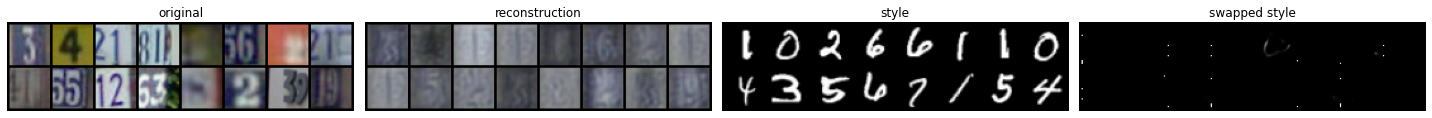

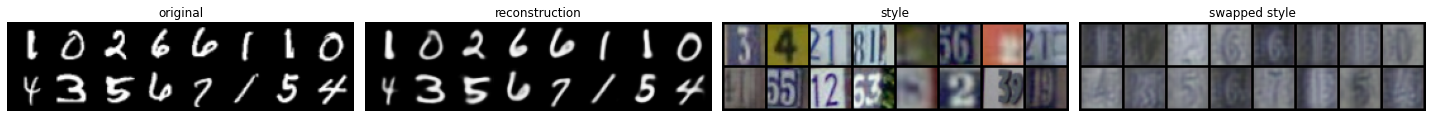

epoch:1 current target accuracy:95.12%:   5%|▌         | 1/20 [01:18<12:29, 39.44s/it]

epoch [2/20], loss:6.5494
accuracy source: 97.56%
accuracy target: 95.12%


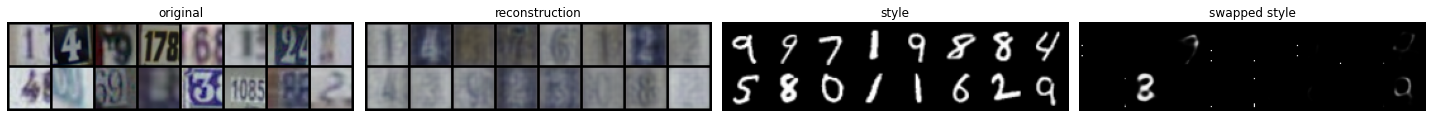

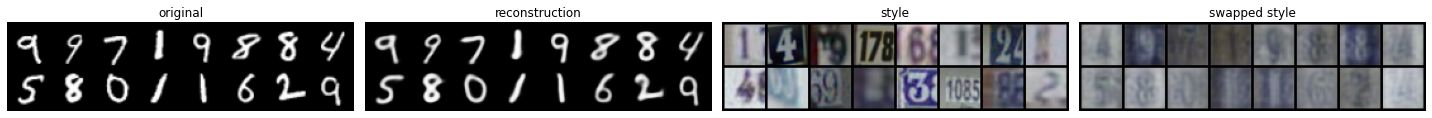

epoch:2 current target accuracy:95.37%:  10%|█         | 2/20 [01:58<11:49, 39.44s/it]

epoch [3/20], loss:6.4999
accuracy source: 97.62%
accuracy target: 95.37%


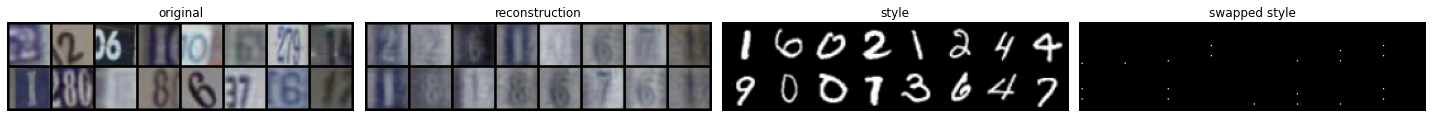

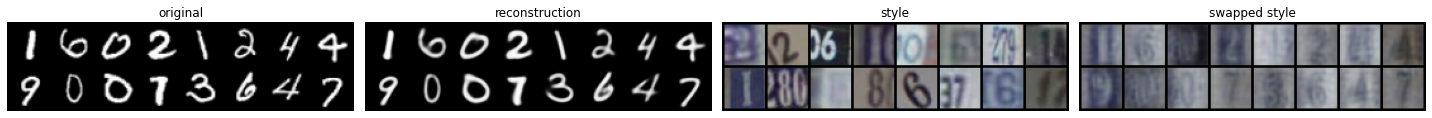

epoch:3 current target accuracy:95.09%:  15%|█▌        | 3/20 [02:37<11:12, 39.55s/it]

epoch [4/20], loss:6.4887
accuracy source: 97.67%
accuracy target: 95.09%


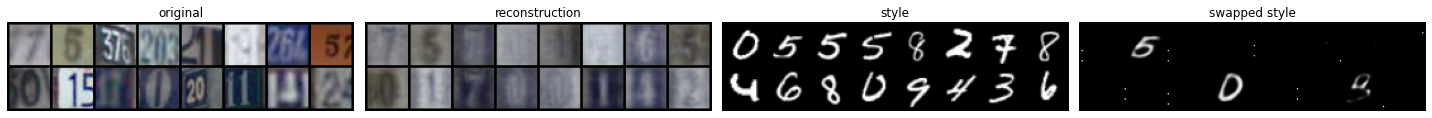

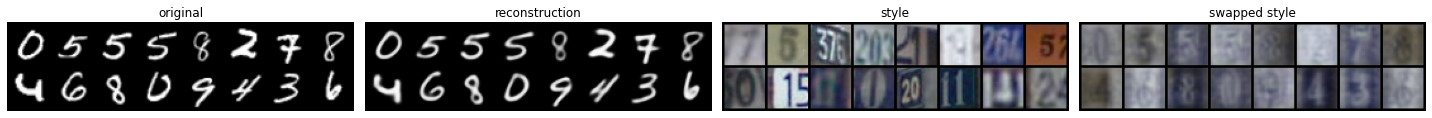

epoch:4 current target accuracy:95.25%:  20%|██        | 4/20 [03:16<10:31, 39.48s/it]

epoch [5/20], loss:6.4704
accuracy source: 97.71%
accuracy target: 95.25%


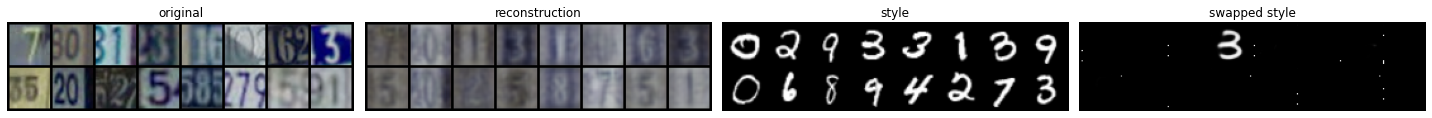

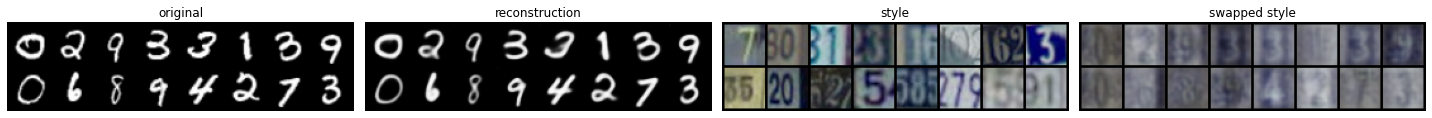

epoch:5 current target accuracy:95.03%:  25%|██▌       | 5/20 [03:56<09:52, 39.51s/it]

epoch [6/20], loss:6.4753
accuracy source: 97.68%
accuracy target: 95.03%


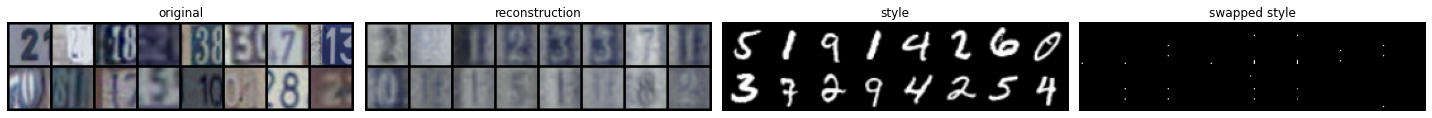

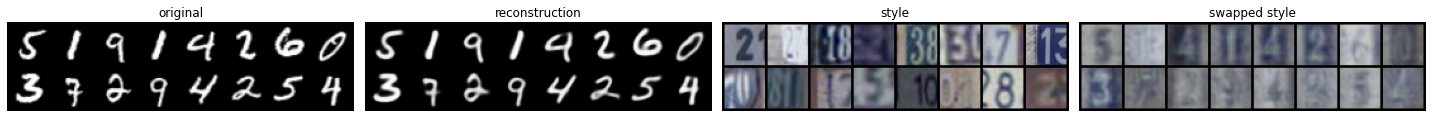

epoch:6 current target accuracy:94.83%:  30%|███       | 6/20 [04:35<09:12, 39.48s/it]

epoch [7/20], loss:6.4478
accuracy source: 97.7%
accuracy target: 94.83%


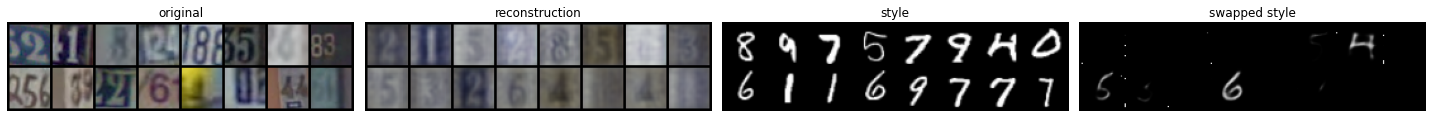

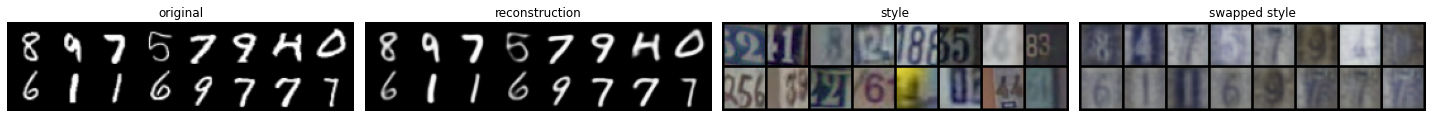

epoch:7 current target accuracy:95.07%:  35%|███▌      | 7/20 [05:15<08:32, 39.46s/it]

epoch [8/20], loss:6.4352
accuracy source: 97.95%
accuracy target: 95.07%


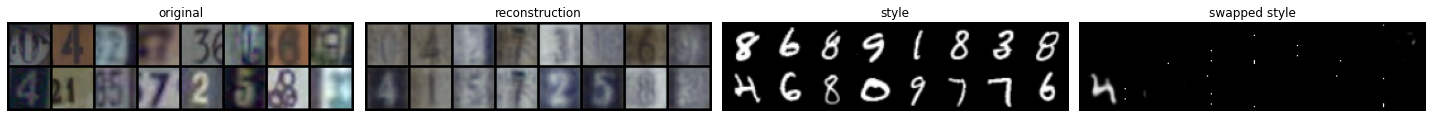

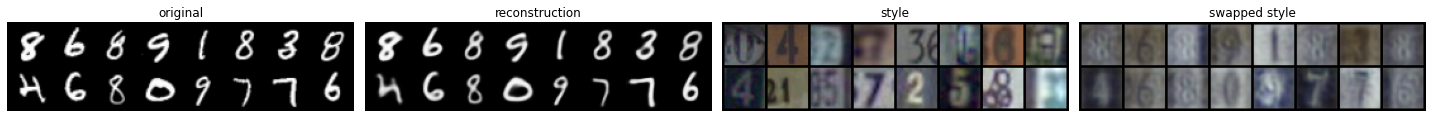

epoch:8 current target accuracy:95.18%:  40%|████      | 8/20 [05:54<07:53, 39.43s/it]

epoch [9/20], loss:6.4289
accuracy source: 97.74%
accuracy target: 95.18%


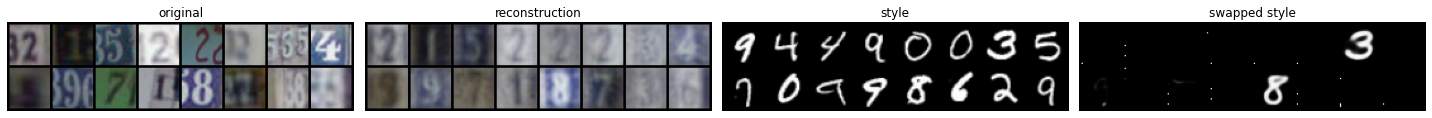

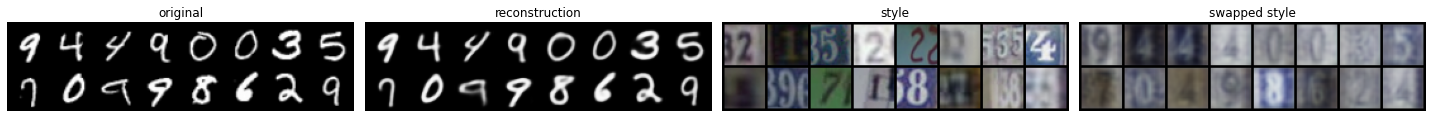

epoch:9 current target accuracy:94.94%:  45%|████▌     | 9/20 [06:33<07:12, 39.32s/it]

epoch [10/20], loss:6.4203
accuracy source: 97.77%
accuracy target: 94.94%


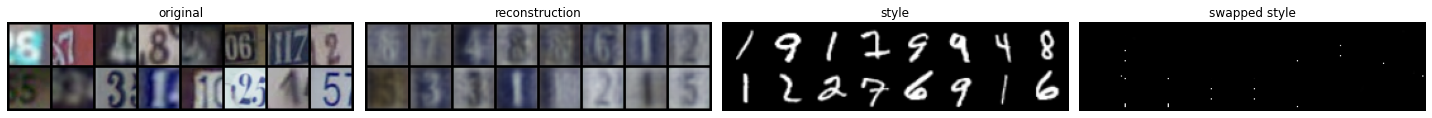

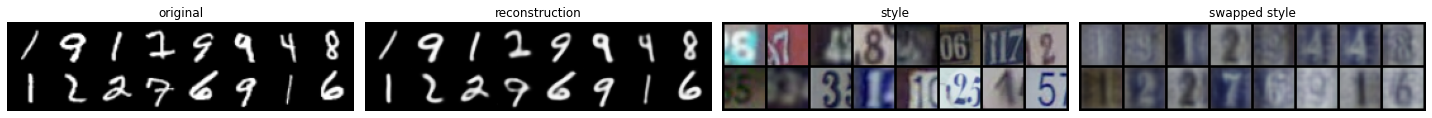

epoch:10 current target accuracy:95.11%:  50%|█████     | 10/20 [07:12<06:32, 39.27s/it]

epoch [11/20], loss:6.4180
accuracy source: 97.84%
accuracy target: 95.11%


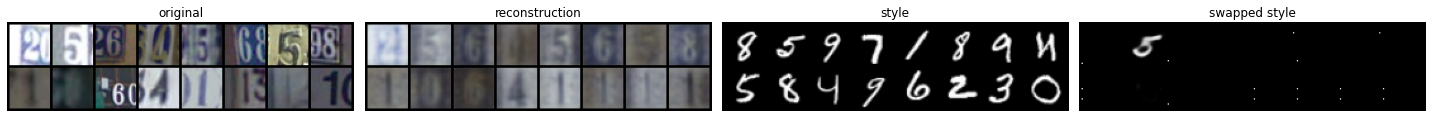

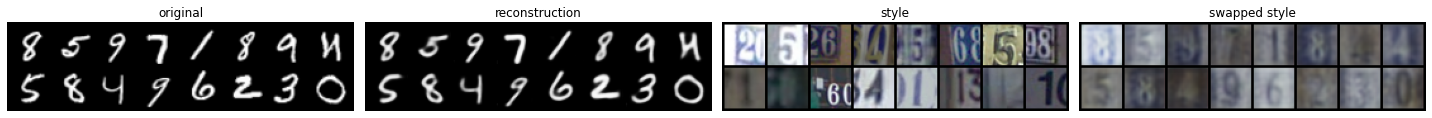

epoch:11 current target accuracy:95.03%:  55%|█████▌    | 11/20 [07:51<05:53, 39.26s/it]

epoch [12/20], loss:6.4037
accuracy source: 97.81%
accuracy target: 95.03%


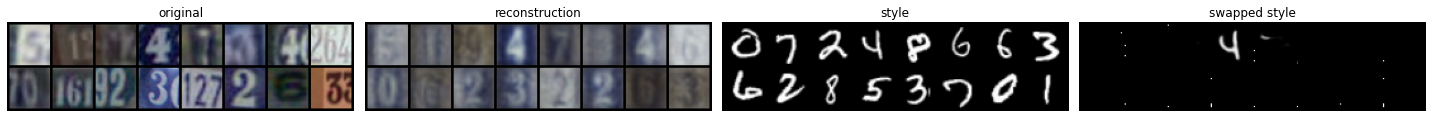

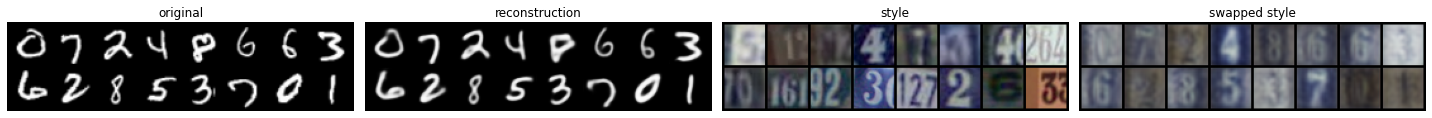

epoch:12 current target accuracy:94.98%:  60%|██████    | 12/20 [08:30<05:13, 39.20s/it]

epoch [13/20], loss:6.3848
accuracy source: 98.1%
accuracy target: 94.98%


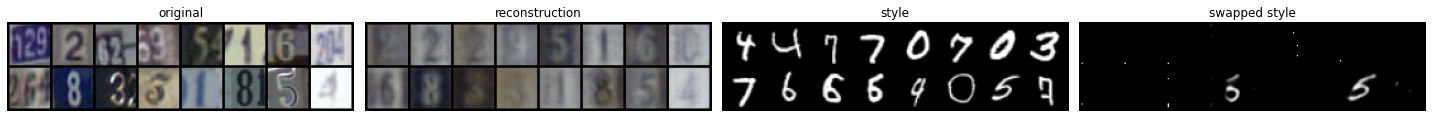

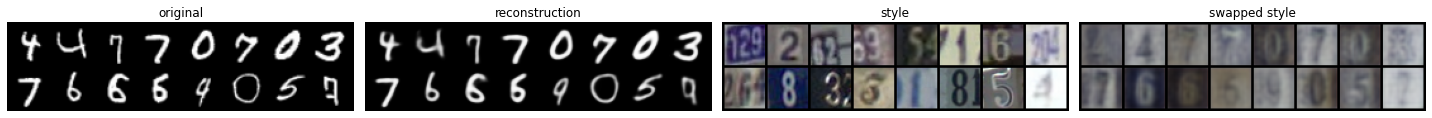

epoch:13 current target accuracy:94.61%:  65%|██████▌   | 13/20 [09:03<04:52, 41.78s/it]


KeyboardInterrupt: 

In [19]:
train_domain_adaptation(model, optimizer, random_projector, source_train_loader, target_train_loader, betas=betas[10:],
                                            epochs=20, alpha=10, delta=delta[10:], gamma=1, show_images=True)

In [ ]:
model.eval()
test_network(model, target_test_loader)

In [ ]:
import matplotlib.pyplot as plt
def plot_target_cross_domain_swapping(model, source_train_loader, target_train_loader):
    X, _ = next(iter(target_train_loader))
    y, _, (z_share, z_spe),  _ = model(X.cuda(), mode='all_target')
    X2, _ = next(iter(source_train_loader))
    _, _, (z_share, _),  _ = model(X2.cuda(), mode='all_target')
    #blank
    plt.subplot(1,6,1)
    plt.imshow(torch.ones((32,32,3)))
    plt.axis('off')
    plt.tight_layout()
    #styles
    for i in range(5):
        plt.subplot(1,6,i+2)
        plt.imshow(X[i].cpu().detach().permute(1, 2, 0))
        plt.axis('off')
        plt.tight_layout()

    for j in range(10, 20):
        plt.figure()
        plt.subplot(1,6,1)
        plt.imshow(X2[j].cpu().detach().permute(1, 2, 0))
        plt.axis('off')
        plt.tight_layout()

        z_x = torch.zeros_like(z_share)
        z_x[:] = z_share[j]
        y2  = model.decoder_target(z_x, z_spe)
        for i in range(5):
            plt.subplot(1,6,i+2)
            plt.imshow(y2[i].cpu().detach().permute(1, 2, 0))
            plt.axis('off')
            plt.tight_layout()

In [ ]:
plot_target_cross_domain_swapping(model, source_train_loader, target_train_loader)
plot_tsne(model, source_train_loader, target_train_loader, 128, 75)